In [1]:
import time
start_time=time.time()

In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import lmfit
from scipy import interpolate
import pickle

from bfunc import bfunc03s

Data load and region parameters

In [3]:
name = 'OrionLH'

In [4]:
reg = 'OrionLH'

In [5]:
pickle_in = open('SFresults//' + name + '.pkl',"rb")
SFresults = pickle.load(pickle_in)

In [6]:
B = SFresults['b2']
r = SFresults['s']
s0 = SFresults['s0']   
m = SFresults['m'] 
#m = 0.25
sig2 = SFresults['sig2'] 
r0 = SFresults['r0'] 
noise = 1/10

In [7]:
model02 = lmfit.Model(bfunc03s)
model02.param_names

['r0', 'sig2', 'm', 's0', 'noise']

In [8]:
relative_uncertainty = 0.125
weights = 1.0 / (relative_uncertainty * B)
weights[r > r0] /= 2.225

In [9]:
for p in model02.param_names:
    model02.set_param_hint(p, min=0.0)
#model02.set_param_hint("sig2", value=sig2, vary=False)
#model02.set_param_hint("s0", min=0.2)
model02.print_param_hints()

Name      Value      Min      Max     Vary    Expr    
m           nan        0      inf     True    
noise       nan        0      inf     True    
r0          nan        0      inf     True    
s0          nan        0      inf     True    
sig2        nan        0      inf     True    


In [10]:
result2 = model02.fit(
    B, 
    weights=weights,
    r = r, r0 = r0, m = m, s0 = s0, noise = 1/10, sig2=sig2,
)

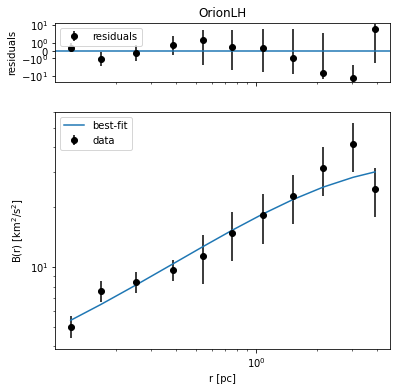

In [11]:
fig, _ = result2.plot( 'ko')
fig.axes[0].set(
    title=reg,
    xscale="log",
    yscale="symlog",
)
fig.axes[1].set(
    xscale = "log",
    yscale = "log",
    xlabel = "r [pc]",
    ylabel = r"B(r) [km$^{2}$/s$^{2}$]",
);

plt.savefig('Imgs//SF//' + reg + '.pdf', bbox_inches='tight')



In [12]:
print(result2.fit_report())

[[Model]]
    Model(bfunc03s)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 111
    # data points      = 11
    # variables        = 5
    chi-square         = 4.73937543
    reduced chi-square = 0.78989591
    Akaike info crit   = 0.73811097
    Bayesian info crit = 2.72758734
[[Variables]]
    r0:     1.01863903 +/- 4.26442505 (418.64%) (init = 0.4530838)
    sig2:   15.3836352 +/- 92.4650833 (601.06%) (init = 10.43385)
    m:      0.87002689 +/- 4.56480308 (524.67%) (init = 0.15)
    s0:     0.01653216 +/- 3.51606705 (21268.04%) (init = 0.04557866)
    noise:  2.68512839 +/- 162.634010 (6056.84%) (init = 0.1)
[[Correlations]] (unreported correlations are < 0.100)
    C(s0, noise)   =  1.000
    C(sig2, m)     = -0.999
    C(sig2, noise) = -0.996
    C(m, noise)    =  0.995
    C(sig2, s0)    = -0.994
    C(m, s0)       =  0.993
    C(r0, s0)      =  0.971
    C(r0, noise)   =  0.968
    C(r0, m)       =  0.942
    C(r0, sig2)    = -0.941


In [13]:
CIresults = {'resultCI' : result2,
            'Rmax/r0' : r.max()/result2.params['r0'].value,
            'lT' : (r[3]/2**0.5)*((result2.params['r0'].value/r[3])**(result2.params['m'].value/2))
          }

In [14]:
f = open('CIresults//' + name +'.pkl',"wb")
pickle.dump(CIresults,f)
f.close()

In [15]:
print('-------------------------------')
print('Parameter    Value       Stderr')
for name, param in result2.params.items():
    print('{:7s} {:11.5f} {:11.5f}'.format(name, param.value, param.stderr))

-------------------------------
Parameter    Value       Stderr
r0          1.01864     4.26443
sig2       15.38364    92.46508
m           0.87003     4.56480
s0          0.01653     3.51607
noise       2.68513   162.63401


In [16]:
for p in result2.model.param_names:
    result2.params[p].stderr = result2.params[p].value * 0.1

In [17]:
result2.conf_interval()
print(result2.ci_report())

C:\Users\ZAINTEL2\anaconda3\lib\site-packages\lmfit\confidence.py:327: UserWarning: rel_change=-0.2884872416919514 < 1e-05 at iteration 8 and prob(r0=0.20372780543948552) = 0.6683584041930801 < max(sigmas).
  warn(errmsg)
C:\Users\ZAINTEL2\anaconda3\lib\site-packages\lmfit\confidence.py:327: UserWarning: rel_change=4.9018380211959435e-09 < 1e-05 at iteration 47 and prob(r0=5.8062424550253295) = 0.6683584081585108 < max(sigmas).
  warn(errmsg)


KeyboardInterrupt: 

plt.style.use([
    "seaborn-poster",
])

plot_limits = {
    "s0": [0.0, 0.1],
    "m": [.5, .5],
    "r0": [0.1, 1.0],
    "noise": [0.0, 0.5],
}

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

plt.title('M8')
levels = [0.6827, 0.9545, 0.9973]
colors = ["g", "y", "r"]

for ax, [xvar, yvar] in zip(axes.flat, [
    ["s0", "noise"],
    ["r0", "m"],
    ["m", "s0"],
    ["r0", "s0"],
]):
    cx, cy, grid = lmfit.conf_interval2d(
        result2, result2, xvar, yvar, 30, 30,
        limits=[plot_limits[xvar], plot_limits[yvar]],
    )
    ctp = ax.contour(cx, cy, grid, levels, colors=colors)
    ax.set_xlabel(xvar)
    ax.set_ylabel(yvar)

fig.tight_layout();

In [ ]:
print("--- %s seconds ---" % (time.time()-start_time))